# Spoken Digits Recognition

Term project for Machine Learning UoT course

The objective of this Notebook is to predict spoken English digits using a Keras model.

This Notebook has three main sections.
1. Extract the features of the WAV files, save them into CSV files and store them into Pandas
2. The model will be trained based on the data set created by https://github.com/Jakobovski/free-spoken-digit-dataset
3. The model will be re-trained based on the previous data plus the recordings made by Ankor (Indian accent), Caroline (Canadian female child accent) and Rodolfo (Brazilian accent)

## Section 1

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : ../data/recordings/train 
testData      : ../data/recordings/test
moreTrainData : ../data/recordings/moreSpeakersTrain
moreTestData  : ../data/recordings/moreSpeakersTest
```


In [1]:
# If true, the WAV files will be read and their features will be saved in the CSV files
# As this is the most time consuming task, only enable it if you don't have the CSV files yet
CREATE_CSV_FILES = True

In [2]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "train.csv"
TEST_CSV_FILE = "test.csv"
MORE_TRAIN_CSV_FILE = "more_train.csv"
MORE_TEST_CSV_FILE = "more_test.csv"


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

if (CREATE_CSV_FILES == True):
    extractWavFeatures("../data/recordings/train", TRAIN_CSV_FILE)
    extractWavFeatures("../data/recordings/test", TEST_CSV_FILE)
    extractWavFeatures("../data/recordings/moreSpeakersTrain", MORE_TRAIN_CSV_FILE)
    extractWavFeatures("../data/recordings/moreSpeakersTest", MORE_TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")


CSV files creation is skipped


In [4]:
#Reading a dataset and convert file name to corresponding number

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    data['number'] = data['filename'].str[:1]
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)
moreTrainData = preProcessData(MORE_TRAIN_CSV_FILE)
moreTestData = preProcessData(MORE_TEST_CSV_FILE)



train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.112672         741.829081          758.492178  1438.494873   
1  0.090344         635.610880          670.336296  1160.452403   
2  0.091456         667.786694          732.606545  1257.180176   
3  0.087751         712.304185          731.292437  1449.104818   
4  0.096603         844.363886          777.868127  1569.583263   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.034023 -295.578461  189.853683 -19.606564   6.078507   
1            0.033458 -339.148743  204.005249  -7.485526  14.297898   
2            0.033268 -327.507416  195.596924  -3.994768  21.315840   
3            0.035916 -320.809937  200.023743  -8.186146  12.661074   
4            0.049465 -315.801300  195.674118 -13.324564   3.544238   

       mfcc5  ...     mfcc12    mfcc13     mfcc14     mfcc15    mfcc16  \
0  22.067095  ... -25.725817 -5.172223 

## Section 2

There are 50 recordings for each digit for each speaker: Jackson, Nicolas and Theo (total 1500 recordings)

Training data has 49 recordings for each digit for each speaker: 1470 recordings total.
Test data has 1 recordings for each digit for each speaker: 30 recordings total.

The data used here comes from the recordings stored in:
* ../data/recordings/train
* ../data/recordings/test

The model will be trained to predict the spoken digit.

In [5]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)


Y from training data: (1029,)
Y from validation data: (441,)
Y from test data: (30,)


In [6]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


X from training data (1029, 25)
X from validation data (441, 25)
X from test data (30, 25)


In [7]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

Using TensorFlow backend.


Train on 1029 samples, validate on 441 samples
Epoch 1/50
1029/1029 [==============================] - 0s 174us/step - loss: 2.3897 - accuracy: 0.1273 - val_loss: 2.1027 - val_accuracy: 0.4082
Epoch 2/50
1029/1029 [==============================] - 0s 34us/step - loss: 2.1667 - accuracy: 0.2060 - val_loss: 1.9653 - val_accuracy: 0.4785
Epoch 3/50
1029/1029 [==============================] - 0s 34us/step - loss: 2.0212 - accuracy: 0.2643 - val_loss: 1.8150 - val_accuracy: 0.5329
Epoch 4/50
1029/1029 [==============================] - 0s 33us/step - loss: 1.8949 - accuracy: 0.3217 - val_loss: 1.6347 - val_accuracy: 0.5714
Epoch 5/50
1029/1029 [==============================] - 0s 31us/step - loss: 1.7318 - accuracy: 0.4004 - val_loss: 1.4544 - val_accuracy: 0.6667
Epoch 6/50
1029/1029 [==============================] - 0s 32us/step - loss: 1.6005 - accuracy: 0.4286 - val_loss: 1.2886 - val_accuracy: 0.6825
Epoch 7/50
1029/1029 [==============================] - 0s 33us/step - loss: 1.509

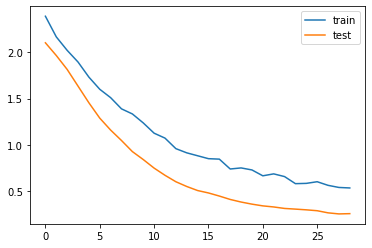

In [8]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Auxiliary functions to show the results

In [9]:
def printPrediction(X_data, y_data):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = model.predict_classes(X_data[i:i+1])
        print("y={}, prediction={}, match={}".format(y_data[i], prediction, y_data[i]==str(prediction[0])))

In [10]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    y_test_num = y_data.astype(np.int64)
    print('Confusion Matrix')
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    
    print('\nClassification Report')
    target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    print(classification_report(y_test_num, Y_pred, target_names=target_names))

### Present the model performance

In [11]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test[0:10], y_test[0:10])


# TEST DATA #

30/30 [==============================] - 0s 32us/step
accuracy: 93.33%

# Generate predictions
y=0, prediction=[0], match=True
y=0, prediction=[3], match=False
y=0, prediction=[0], match=True
y=1, prediction=[1], match=True
y=1, prediction=[1], match=True
y=1, prediction=[1], match=True
y=2, prediction=[2], match=True
y=2, prediction=[2], match=True
y=2, prediction=[3], match=False
y=3, prediction=[3], match=True


Classification Report for Test Data

Confusion Matrix
[[2 0 0 1 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 3]]


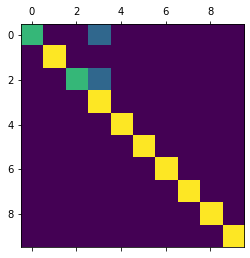


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           0.93        30
   macro avg       0.96      0.93      0.93        30
weighted avg       0.96      0.93      0.94        30



In [12]:
print("Classification Report for Test Data\n")
report(X_test, y_test)


## Section 3

There are 50 recordings for each digit for each speaker: Jackson, Nicolas and Theo (total 1500 recordings)
Training data has 49 recordings for each digit for each speaker: 1470 recordings total.
Test data has 1 recordings for each digit for each speaker: 30 recordings total.

In addition, there are 2 recordings for each digit for each speaker: Ankur, Caroline and Rodolfo (total 60 recordings)
This addition training data has 1 recordings for each digit for each speaker: 30 recordings total.
This addition test data has 1 recordings for each digit for each speaker: 30 recordings total.

Therefore the full data set has:
* Training: 1500 recordings
* Training: 60 recordings

The data used here comes from the recordings stored in:
* ../data/recordings/train
* ../data/recordings/test
* ../data/recordings/moreSpeakersTrain
* ../data/recordings/moreSpeakersTest

In [13]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split

fullTrainData = trainData.append(moreTrainData)

X = np.array(fullTrainData.iloc[:, :-1], dtype = float)
y = fullTrainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

X_more_test = np.array(moreTestData.iloc[:, :-1], dtype = float)
y_more_test = moreTestData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)
print("Y from other speakers test data:", y_more_test.shape)


Y from training data: (1050,)
Y from validation data: (450,)
Y from test data: (30,)
Y from other speakers test data: (30,)


In [14]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )
X_more_test = scaler.transform( X_more_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)
print("X from other speakers test data", X_more_test.shape)


X from training data (1050, 25)
X from validation data (450, 25)
X from test data (30, 25)
X from other speakers test data (30, 25)


In [15]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

Train on 1050 samples, validate on 450 samples
Epoch 1/50
1050/1050 [==============================] - 0s 187us/step - loss: 2.3702 - accuracy: 0.1181 - val_loss: 2.1133 - val_accuracy: 0.3867
Epoch 2/50
1050/1050 [==============================] - 0s 34us/step - loss: 2.1797 - accuracy: 0.2000 - val_loss: 1.9892 - val_accuracy: 0.5111
Epoch 3/50
1050/1050 [==============================] - 0s 34us/step - loss: 2.0564 - accuracy: 0.2533 - val_loss: 1.8383 - val_accuracy: 0.5267
Epoch 4/50
1050/1050 [==============================] - 0s 33us/step - loss: 1.9256 - accuracy: 0.2819 - val_loss: 1.6646 - val_accuracy: 0.5622
Epoch 5/50
1050/1050 [==============================] - 0s 33us/step - loss: 1.7396 - accuracy: 0.3933 - val_loss: 1.4607 - val_accuracy: 0.6089
Epoch 6/50
1050/1050 [==============================] - 0s 37us/step - loss: 1.6236 - accuracy: 0.3981 - val_loss: 1.2735 - val_accuracy: 0.6622
Epoch 7/50
1050/1050 [==============================] - 0s 36us/step - loss: 1.475

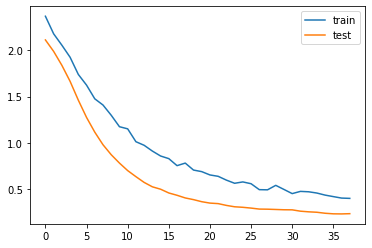

In [16]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Present the model performance

In [17]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test[0:10], y_test[0:10])


# TEST DATA #

30/30 [==============================] - 0s 33us/step
accuracy: 90.00%

# Generate predictions
y=0, prediction=[0], match=True
y=0, prediction=[3], match=False
y=0, prediction=[0], match=True
y=1, prediction=[1], match=True
y=1, prediction=[4], match=False
y=1, prediction=[1], match=True
y=2, prediction=[2], match=True
y=2, prediction=[2], match=True
y=2, prediction=[3], match=False
y=3, prediction=[3], match=True


In [18]:
print('\n# OTHER SPEAKERS DATA #\n')
score = model.evaluate(X_more_test, y_more_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_more_test[0:10], y_more_test[0:10])



# OTHER SPEAKERS DATA #

30/30 [==============================] - 0s 67us/step
accuracy: 26.67%

# Generate predictions
y=0, prediction=[3], match=False
y=0, prediction=[0], match=True
y=0, prediction=[1], match=False
y=1, prediction=[0], match=False
y=1, prediction=[9], match=False
y=1, prediction=[9], match=False
y=2, prediction=[2], match=True
y=2, prediction=[8], match=False
y=2, prediction=[6], match=False
y=3, prediction=[3], match=True


Classification Report for Test Data

Confusion Matrix
[[2 0 0 1 0 0 0 0 0 0]
 [0 2 0 0 1 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 3]]


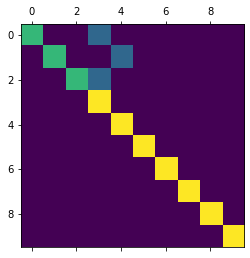


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.67      0.80         3
           2       1.00      0.67      0.80         3
           3       0.60      1.00      0.75         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3

    accuracy                           0.90        30
   macro avg       0.93      0.90      0.90        30
weighted avg       0.94      0.90      0.90        30

Classification Report for Other Speakers

Confusion Matrix
[[1 1 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 2]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 0 1 1 0 0 0]
 [0 0 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 2 0 1 0

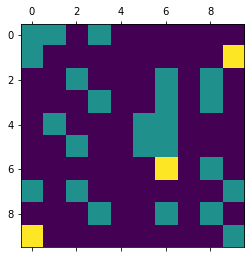


Classification Report
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.00      0.00      0.00         3
           2       0.33      0.33      0.33         3
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         3
           5       0.50      0.33      0.40         3
           6       0.29      0.67      0.40         3
           7       0.00      0.00      0.00         3
           8       0.25      0.33      0.29         3
           9       0.25      0.33      0.29         3

    accuracy                           0.27        30
   macro avg       0.22      0.27      0.23        30
weighted avg       0.22      0.27      0.23        30



c:\users\erodvas\env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

print("Classification Report for Other Speakers\n")
report(X_more_test, y_more_test)
